# Data exploration notebook

In this notebook, we will explore the input data obtained using the [ATLAS-simplified](https://github.com/mpitt82/Geant4-models/tree/master/ATLAS-simplified) Geant4 simulation model. The data files are available [here](https://cernbox.cern.ch/index.php/s/oCg3en1GHAvYSTo?path=%2FCalo_RectangularGeo_diPion64x64%2Frun).

The exploration is done using the [uproot](https://pypi.org/project/uproot/) module. This exploration notebook is used to obtain the input data in the numpy array format using a proper script. 



Standards imports

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import h5py
import urllib.request
from particleImages_helpers import CellToMatrix, DrawEvent

### Loading the data

With [uproot](https://pypi.org/project/uproot/), we can limit the number of events that will be loaded to the cache.

In this example, we will download a single file from cernbox folder (events_train.root), which have $\sim$45k events.

In [2]:
url = 'https://cernbox.cern.ch/index.php/s/Eg5EBmimOqAUd3f/download'
urllib.request.urlretrieve(url, 'events_fromcernbox.root')

('events_fromcernbox.root', <http.client.HTTPMessage at 0x2907002f198>)

In [3]:
inputfile = 'events_fromcernbox.root' #'data/events.root'
f = uproot.open(inputfile)
print('file content:')
for key in f.keys(): print(key)
tree = f['physics']
print('Total number of events in the file = '+str(tree.numentries))

file content:
b'physics;1'
Total number of events in the file = 44850


## Particle gun

The first task will be to see the distribution of the particles, generated with the particle gun. The mission is to distinguish between calorimeter hits caused by two different particle types. To have an unbiased training set, we need that the particles will be generated uniformly covering all possible separations, and angular distributions.

Load branches that correspond to the particle initial momentum and position. Particle is 1.5m away from the calorimeter first layer. The location of the first interation between the particle and the calorimeter can be calculated from $ r_\text{CAL} = r_0 + \Delta r = r_0 + p_r \times \left(\Delta z/p_z\right)$, where $r=\{x,y\}$.

In [13]:
particle_x = tree.array('particle_x')
particle_y = tree.array('particle_y')
particle_z = tree.array('particle_z')
particle_px = tree.array('particle_px')
particle_py = tree.array('particle_py')
particle_pz = tree.array('particle_pz')
particle_e = tree.array('particle_e')
particle_pdgid = tree.array('particle_pdgId')
dz = 1500 # in mm

Particle types, the first one should be $\pi^+$ while the second particle should be $\pi^0$

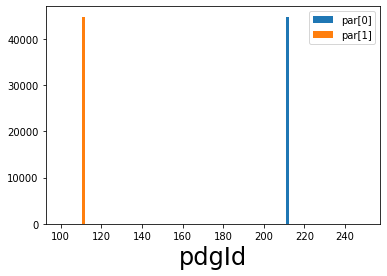

In [5]:
plt.hist([id[0] for id in particle_pdgid],100,[100,250],label='par[0]')
plt.hist([id[1] for id in particle_pdgid],100,[100,250],label='par[1]')
plt.legend(); plt.xlabel('pdgId',fontsize=24); plt.show()

### Spectra of pions:

energy correlation between pions from the data sample:

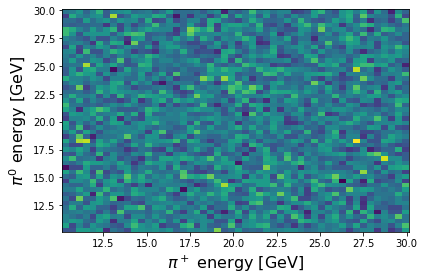

In [16]:
plt.hist2d([e[0] for e in particle_e],[e[1] for e in particle_e],bins=50)
plt.xlabel('$\pi^+$ energy [GeV]',fontsize=16); plt.ylabel('$\pi^0$ energy [GeV]',fontsize=16)
plt.tight_layout(); plt.show()

### Spatial distribution
Distribution of particle gun at $z = -1.5$ m. The Left plot is for $\pi^+$ and the right plot is for $\pi^0$

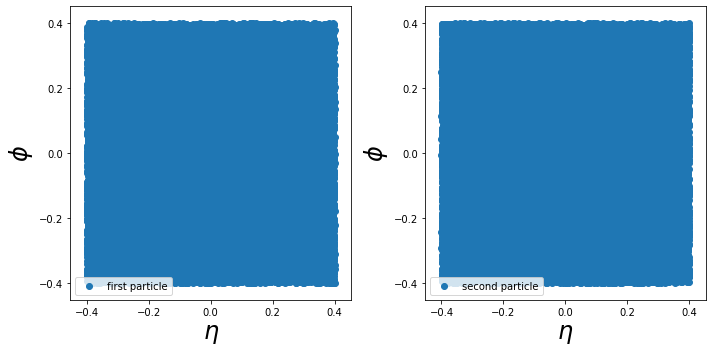

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].scatter([x[0]/1440 for x in particle_x],[x[0]/1440 for x in particle_y],label='first particle')
axes[0].set_xlabel('$\eta$',fontsize=24); axes[0].set_ylabel('$\phi$',fontsize=24); axes[0].legend()
axes[1].scatter([x[1]/1440 for x in particle_x],[x[1]/1440 for x in particle_y],label='second particle')
axes[1].set_xlabel('$\eta$',fontsize=24); axes[1].set_ylabel('$\phi$',fontsize=24); axes[1].legend()
plt.tight_layout(); plt.show()

Distribution of particle gun at the first calorimeter layer. The Left plot is for $\pi^+$ and the right plot is for $\pi^0$

In [7]:
eta_cal_par1 = [(x[0]+px[0]*dz/pz[0])/1440 for x,px,pz in zip(particle_x,particle_px,particle_pz)]
phi_cal_par1 = [(x[0]+px[0]*dz/pz[0])/1440 for x,px,pz in zip(particle_y,particle_py,particle_pz)]
eta_cal_par2 = [(x[1]+px[1]*dz/pz[1])/1440 for x,px,pz in zip(particle_x,particle_px,particle_pz)]
phi_cal_par2 = [(x[1]+px[1]*dz/pz[1])/1440 for x,px,pz in zip(particle_y,particle_py,particle_pz)]

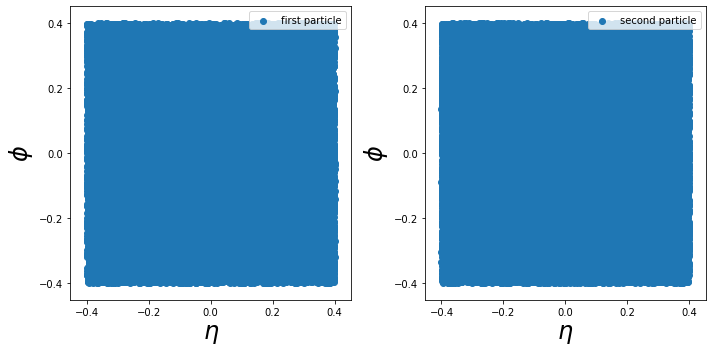

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].scatter(eta_cal_par1,phi_cal_par1,label='first particle')
axes[0].set_xlabel('$\eta$',fontsize=24); axes[0].set_ylabel('$\phi$',fontsize=24); axes[0].legend()
axes[1].scatter(eta_cal_par2,phi_cal_par2,label='second particle')
axes[1].set_xlabel('$\eta$',fontsize=24); axes[1].set_ylabel('$\phi$',fontsize=24); axes[1].legend()
plt.tight_layout(); plt.show()

Distribution of $\Delta\eta$,$\Delta\phi$ between two particles when they hit the first calorimeter layer:

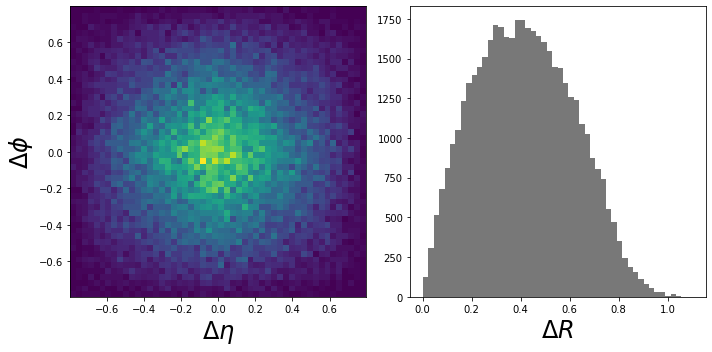

In [9]:
deta = [dx[0]-dx[1] for dx in zip(eta_cal_par1,eta_cal_par2)]
dphi = [dx[0]-dx[1] for dx in zip(phi_cal_par1,phi_cal_par2)]
dR = [np.sqrt(x[0]**2+x[1]**2) for x in zip(deta,dphi)]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].hist2d(deta,dphi,bins=50)
axes[0].set_xlabel('$\Delta\eta$',fontsize=24); axes[0].set_ylabel('$\Delta\phi$',fontsize=24)
axes[1].hist(dR,bins=50,color='k',alpha=0.53)
axes[1].set_xlabel('$\Delta R$',fontsize=24)
plt.tight_layout(); plt.show()

### Calorimeter images

In this section, we will create calorimeter images from the cell hits

In [10]:
minitree = uproot.open('data/events.root')['physics'] #use smaller file, since the output will be x50 times larger

In [11]:
#calorimeter images - setup
cellCh_Energy,cellNu_Energy = CellToMatrix(minitree, nPixEta = 64, nPixPhi = 64)
print('cellCh_Energy.shape',cellCh_Energy.shape)
print('cellNu_Energy.shape',cellNu_Energy.shape)

using total 2100 events
progress |##################################################| 100.0%
cell_Energy.shape (2100, 6, 64, 64)
cellCh_Energy.shape (2100, 6, 64, 64)
cellNu_Energy.shape (2100, 6, 64, 64)


Draw a random image from the energy matrices:

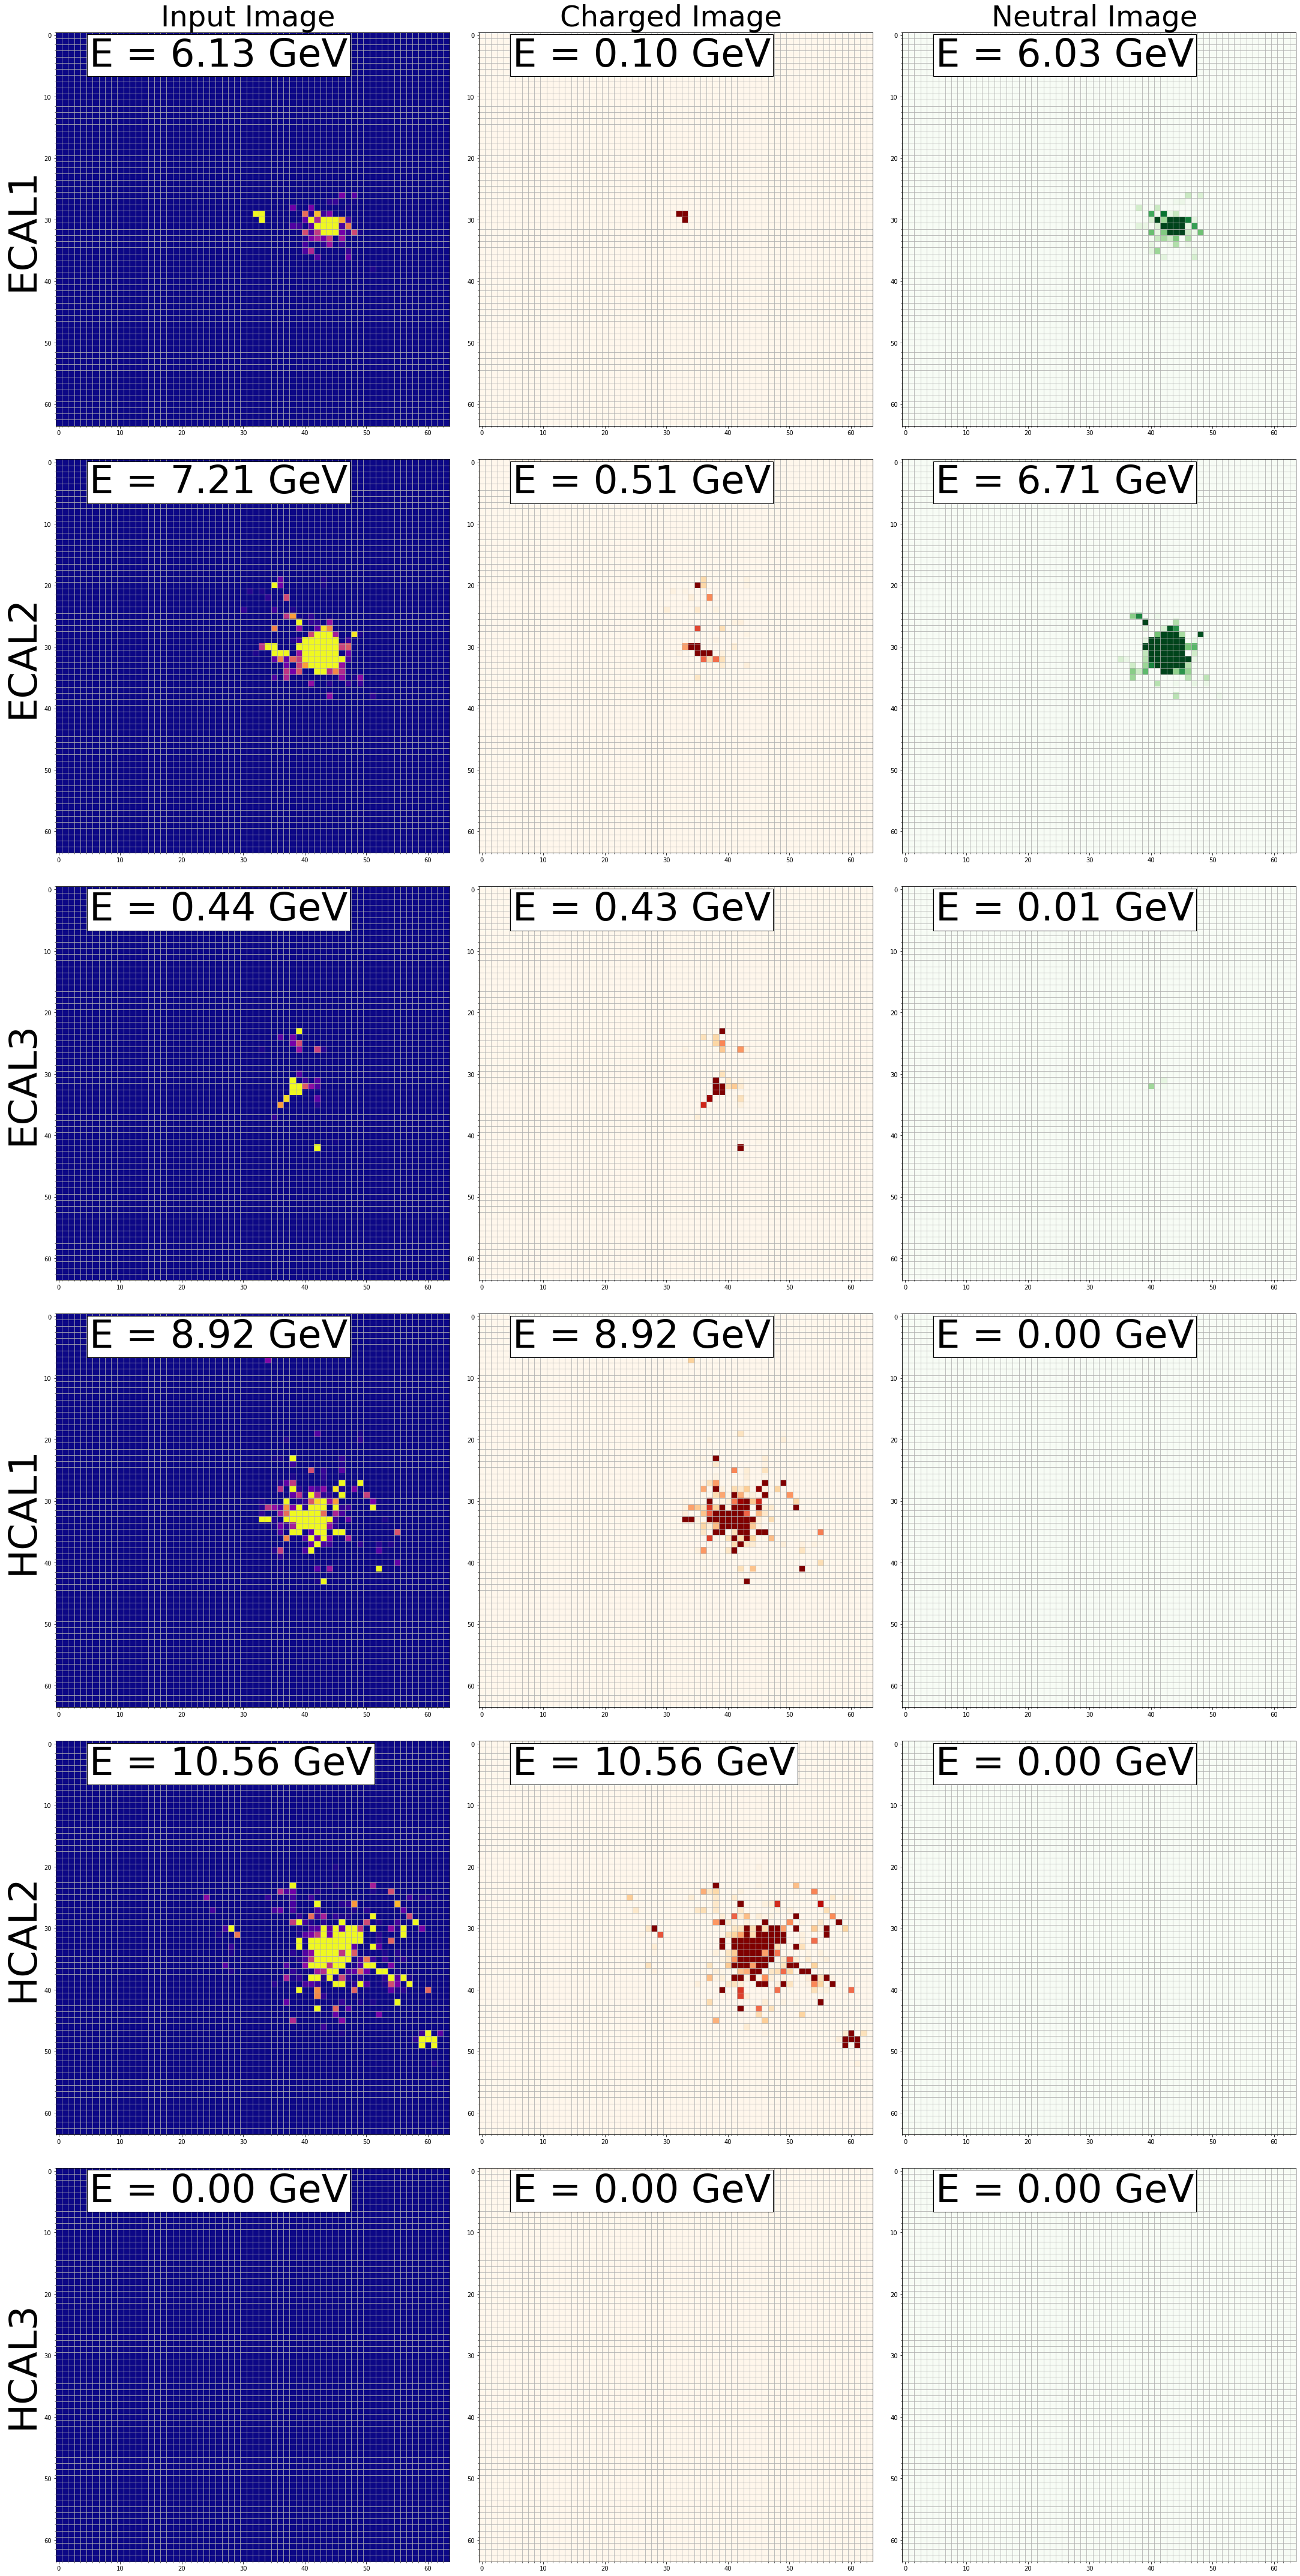

In [12]:
DrawEvent(event = 200, cellCh_Energy=cellCh_Energy, cellNu_Energy=cellNu_Energy)

<font color=red>**NOTE:** the output size of a matrix is $\times50$ times larger than the input file, verify that you have enough memory!!!</font>

### Save input data as h5py file

Save the data as .h5 file for future analysis. The D=$64\times64$ images will be used for segmentation and super-resolution tasks. 

In [ ]:
with h5py.File('data/'+filename.replace('root','h5'), 'w') as f:
    f.create_dataset('cellCh_Energy', data=cellCh_Energy)
    f.create_dataset('cellNu_Energy', data=cellNu_Energy)

### Save input data as numpy object

Save the data two files charged(neutral).npy file for future analysis. The D=$64\times64$ images will be used for segmentation and super-resolution tasks. 

In [ ]:
np.save('data/charged_'+filename.replace('root','npy'),cellCh_Energy)
np.save('data/neutral_'+filename.replace('root','npy'),cellNu_Energy)